In [161]:
import torch 
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.decomposition import PCA

In [162]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import re
import json
import pandas as pd

In [179]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [180]:
with open("/home/labpc1/Documents/Project/QAS/dataset/iot1500_cuted.json") as f:
    content = json.load(f)

In [181]:
corpus = ""

In [182]:
for i, item in enumerate(content):
#     print(item)
    if item['content'] != "（本講座文案仍在撰寫中，將於近期上架，精彩故事／校系介紹請直接點選影片觀看！）":
        word_seg = item['articut']
        corpus += word_seg

In [183]:
len(corpus)

5201195

In [184]:
corpus = corpus.split("/")

In [185]:
words = []
for idx, t in enumerate(corpus):
    t = t.replace("，", "").replace("。", "").replace("」", "").replace("「", "").replace("、", "").replace("（", "")\
    .replace("）", "").replace(",", "").replace("⋯", "").replace("？", "").replace("！", "")
    if len(t) > 0:
#         print(t)
        words.append(t)

In [186]:
words = words[:100000]

In [187]:
trigrams = [([words[i], words[i + 1]], words[i + 2]) for i in range(len(words) - 2)]

In [188]:
trigrams[:3]

[(['堅持', '追'], '夢'), (['追', '夢'], '成為'), (['夢', '成為'], '能夠')]

In [189]:
vocab = set(words)
print(len(vocab))

6944


In [190]:
word_to_idx = {} 
idx_to_word = {}
ids = 0

for w in words:
    cnt = word_to_idx.get(w, [ids, 0])
    if cnt[1] == 0:
        ids += 1
    cnt[1] += 1
    word_to_idx[w] = cnt
    idx_to_word[ids] = w

In [191]:
s = 0
for key, value in word_to_idx.items():
    print(key, value)
    s += 1
    if s > 5:
        break

堅持 [0, 15]
追 [1, 2]
夢 [2, 4]
成為 [3, 80]
能夠 [4, 89]
撐起 [5, 1]


## Model

In [218]:
class NGram(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size*embedding_dim, 256)
        self.linear2 = nn.Linear(256, vocab_size)
        
    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        embeds = embeds.view(1, -1)
        out = self.linear1(embeds)
        out = F.relu(out)
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim = 1)
        return log_probs
    
    def extract(self, inputs):
        embeds = self.embeddings(inputs)
        return embeds

In [219]:
losses = []
criterion = nn.NLLLoss().to(device)
model = NGram(len(vocab), 10, 2).to(device)
optimizer = optim.Adam(model.parameters(), lr = 2e-4)

In [220]:
from tqdm import tqdm

In [ ]:
for epoch in range(30):
    total_loss = torch.Tensor([0])
    
    for context, target in tqdm(trigrams):
        context_idxs = [word_to_idx[w][0] for w in context]
        context_var = torch.tensor(context_idxs, dtype = torch.long).to(device)
        
        optimizer.zero_grad()
        
        log_probs = model(context_var)
        loss = criterion(log_probs, torch.tensor([word_to_idx[target][0]], dtype = torch.long).to(device))
        loss.backward()
        optimizer.step()
#         print(loss)
        loss = loss.cpu()
#         print(loss)
        total_loss += loss.data
        
    losses.append(total_loss)
    print(f"epoch: {epoch: 2d}, loss: {total_loss.numpy()[0]: .2f}")

  0%|          | 96/99998 [00:00<01:45, 948.95it/s]

epoch:  0, loss:  705936.12


  0%|          | 91/99998 [00:00<01:50, 901.99it/s]

epoch:  1, loss:  765625.00


  0%|          | 190/99998 [00:00<01:44, 950.69it/s]

epoch:  2, loss:  793559.31


  0%|          | 89/99998 [00:00<01:52, 884.41it/s]

epoch:  3, loss:  798289.75


  0%|          | 97/99998 [00:00<01:43, 961.58it/s]

epoch:  4, loss:  795086.62


  0%|          | 97/99998 [00:00<01:43, 968.91it/s]

epoch:  5, loss:  782430.75


  0%|          | 93/99998 [00:00<01:47, 926.52it/s]

epoch:  6, loss:  768567.94


  0%|          | 84/99998 [00:00<01:59, 834.83it/s]

epoch:  7, loss:  759199.62


  0%|          | 91/99998 [00:00<01:50, 901.70it/s]

epoch:  8, loss:  753394.31


  0%|          | 89/99998 [00:00<01:52, 886.31it/s]

epoch:  9, loss:  750240.00


  0%|          | 93/99998 [00:00<01:48, 923.74it/s]

epoch:  10, loss:  747819.88


  0%|          | 95/99998 [00:00<01:45, 947.51it/s]

epoch:  11, loss:  745536.19


  0%|          | 93/99998 [00:00<01:48, 920.62it/s]

epoch:  12, loss:  743103.12


  0%|          | 86/99998 [00:00<01:56, 856.46it/s]

epoch:  13, loss:  740094.31


  0%|          | 92/99998 [00:00<01:49, 911.39it/s]

epoch:  14, loss:  734240.56


  0%|          | 91/99998 [00:00<01:50, 904.87it/s]

epoch:  15, loss:  727235.62


  0%|          | 89/99998 [00:00<01:52, 887.71it/s]

epoch:  16, loss:  725978.88


 28%|██▊       | 27626/99998 [00:30<01:20, 904.21it/s]

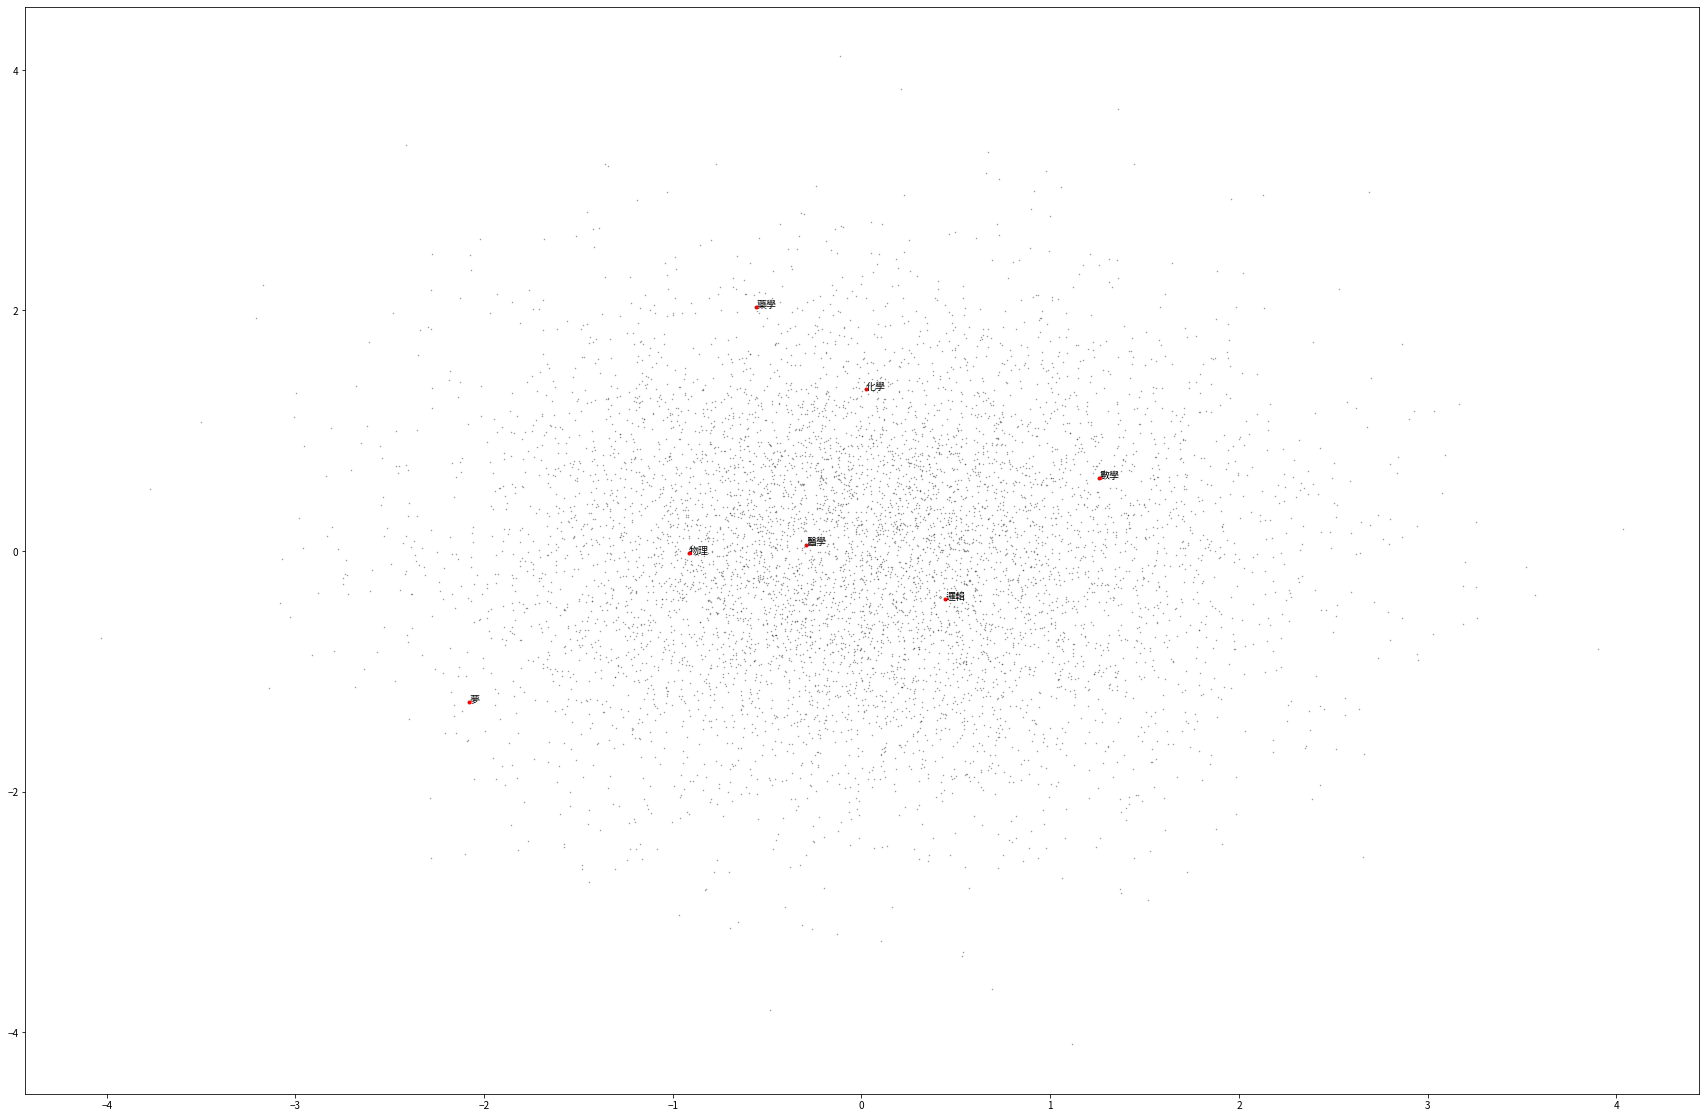

In [99]:
vec = model.extract(torch.tensor([v[0] for v in word_to_idx.values()], dtype = torch.long))
vec = vec.data.numpy()

X_reduced = PCA(n_components=2).fit_transform(vec)


fig = plt.figure(figsize = (30, 20))
ax = fig.gca()
ax.set_facecolor('white')
ax.plot(X_reduced[:, 0], X_reduced[:, 1], '.', markersize = 1, alpha = 0.4, color = 'black')


words = ['醫學', "夢", '藥學', '化學', '地球科學', '物理', '數學', '外文', '邏輯']

plt.rcParams['font.family']=['Noto Sans CJK JP']

for w in words:
    if w in word_to_idx:
        ind = word_to_idx[w][0]
        xy = X_reduced[ind]
        plt.plot(xy[0], xy[1], '.', alpha =1, color = 'red')
        plt.text(xy[0], xy[1], w, alpha = 1, color = 'black')

# Word2vec

In [101]:
import gensim as gensim
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from gensim.models.word2vec import LineSentence

/home/labpc1/anaconda3/envs/bert/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [104]:
import jieba

In [110]:
# ??jieba

In [109]:
f = open("/home/labpc1/Documents/Research/Dataset/HE/prepared/大唐雙龍傳_prepared.txt", 'r')
lines = []
for line in f:
    temp = jieba.cut(line)
    words = []
    for i in temp:
        #过滤掉所有的标点符号
        i = re.sub("[\s+\.\!\/_,$%^*(+\"\'””《》]+|[+——！，。？、~@#￥%……&*（）：；‘]+", "", i)
        if len(i) > 0:
            words.append(i)
    if len(words) > 0:
        lines.append(words)

Building prefix dict from /home/labpc1/anaconda3/envs/bert/lib/python3.6/site-packages/jieba/dict.txt ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.6301426887512207 seconds.
Prefix dict has been built succesfully.


In [111]:
# !pip list jieba

In [116]:
model = Word2Vec(lines, vector_size = 100, window = 3 , min_count = 0)

In [118]:
model.wv.most_similar('寇仲', topn = 20)

[('侯希白', 0.8378050923347473),
 ('可達志', 0.801302969455719),
 ('兩人', 0.7719804048538208),
 ('徐子陵', 0.7712764143943787),
 ('突利', 0.7632129192352295),
 ('雷九指', 0.7538612484931946),
 ('宋玉致', 0.7391961216926575),
 ('商秀珣', 0.7336829304695129),
 ('三人', 0.726085364818573),
 ('素素', 0.722058892250061),
 ('尤鳥倦', 0.7213938236236572),
 ('會心', 0.7184790968894958),
 ('李靖', 0.7152235507965088),
 ('婠婠', 0.7049986124038696),
 ('雲玉真', 0.7021227478981018),
 ('紀倩', 0.6983763575553894),
 ('安隆', 0.6967732906341553),
 ('陰顯鶴', 0.6919008493423462),
 ('曹應龍', 0.6878729462623596),
 ('眾人', 0.685767412185669)]

In [138]:
rawWordVec = []
word2ind = model.wv.key_to_index
for k, i in word2ind.items():
    word_vec = model.wv.get_vector(k)
    rawWordVec.append(word_vec)
    
rawWordVec = np.array(rawWordVec)
X_reduced = PCA(n_components=2).fit_transform(rawWordVec)

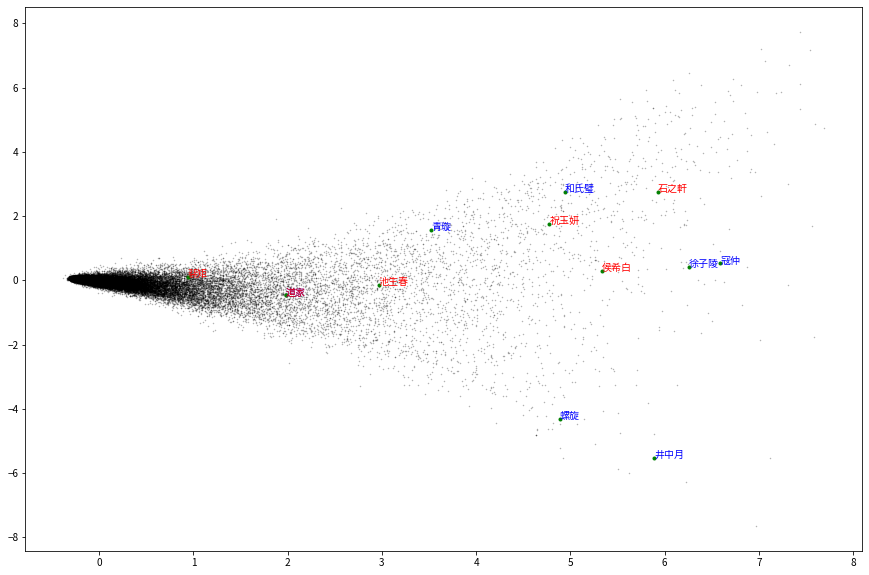

In [158]:
fig = plt.figure(figsize = (15, 10))
ax = fig.gca()
ax.set_facecolor('white')
ax.plot(X_reduced[:, 0], X_reduced[:, 1], '.', markersize = 1, alpha = 0.3, color = 'black')

words = ['寇仲', '井中月', '和氏璧', '螺旋', '道家', "徐子陵", "青璇"]

for w in words:
    if w in word2ind:
        ind = word2ind[w]
        xy = X_reduced[ind]
        plt.plot(xy[0], xy[1], '.', alpha =1, color = 'green')
        plt.text(xy[0], xy[1], w, alpha = 1, color = 'blue')
        
words = ['祝玉妍', '石之軒', '池生春', '裴矩', '侯希白', '道家']

for w in words:
    if w in word2ind:
        ind = word2ind[w]
        xy = X_reduced[ind]
        plt.plot(xy[0], xy[1], '.', alpha =1, color = 'green')
        plt.text(xy[0], xy[1], w, alpha = 1, color = 'red')

In [148]:
model.wv.most_similar('裴矩', topn = 20)

[('楊公', 0.9516226053237915),
 ('秘技', 0.9439753293991089),
 ('池生春', 0.9416953921318054),
 ('楊文', 0.9396265745162964),
 ('堂主', 0.9396028518676758),
 ('秀心', 0.938917875289917),
 ('大俠', 0.9388221502304077),
 ('劉弘', 0.937330424785614),
 ('楊廣', 0.9372840523719788),
 ('老嘆', 0.9353212118148804),
 ('隆叔', 0.9337180852890015),
 ('無知', 0.9330700039863586),
 ('老方', 0.9318176507949829),
 ('胡佛', 0.9313461780548096),
 ('此女', 0.9308068752288818),
 ('榮鳳祥', 0.9307466149330139),
 ('岳老', 0.9297339916229248),
 ('師尊', 0.9295783042907715),
 ('鐵弗由', 0.9295074343681335),
 ('可風', 0.9294668436050415)]

In [160]:
words = model.wv.most_similar(positive=['婠婠', '徐子陵'], negative=['青璇'])
words

[('兩人', 0.7160928845405579),
 ('三人', 0.6524981260299683),
 ('侯希白', 0.6486637592315674),
 ('可達志', 0.6346345543861389),
 ('你動', 0.6288372874259949),
 ('寇仲', 0.626163125038147),
 ('宋玉致', 0.6194859743118286),
 ('石之軒', 0.617201566696167),
 ('寇仲聞言', 0.6159948110580444),
 ('眾人', 0.6087265014648438)]

In [ ]:
fas